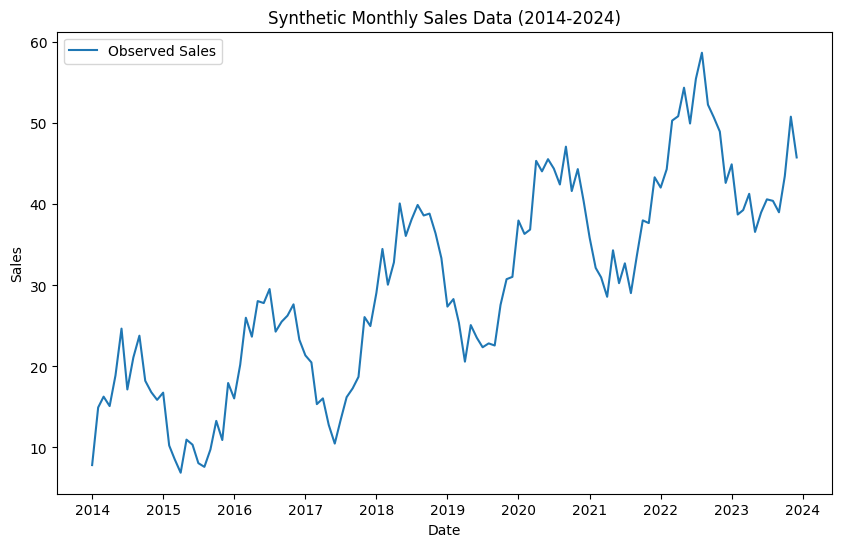

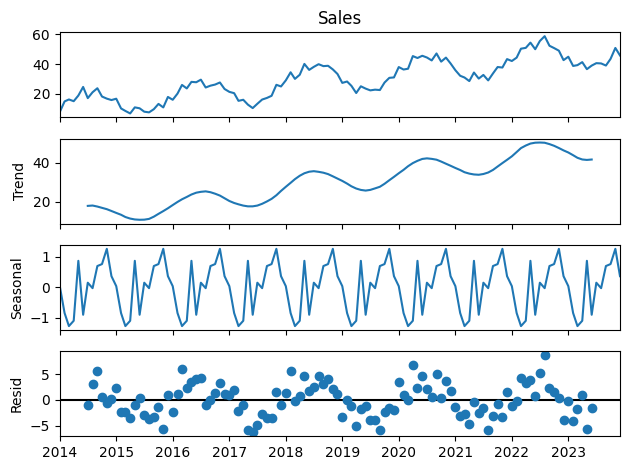

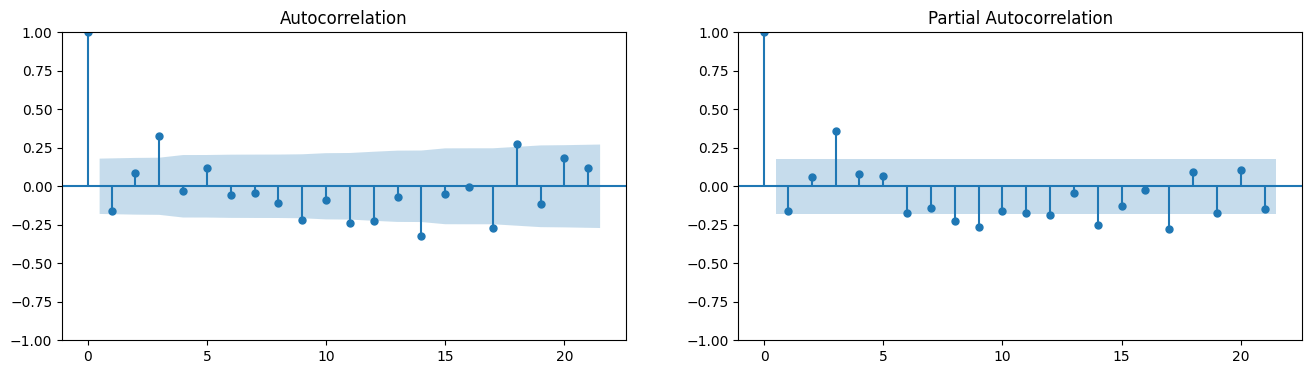

Fitting the model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -264.615
Date:                            Wed, 28 Jan 2026   AIC                            539.230
Time:                                    11:13:28   BIC                            551.999
Sample:                                01-01-2014   HQIC                           544.389
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1501      0.243     -0.619      0.536      -0.626       0.325
ma.L1         -0.3438      0.237   

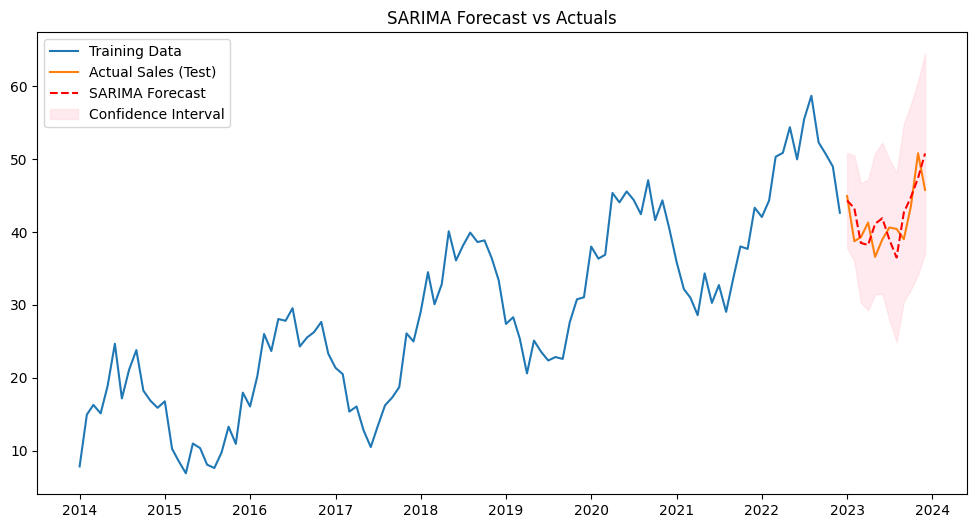

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# ==========================================
# 1. Data Generation
# ==========================================
# I'm creating a synthetic dataset here to simulate monthly sales data
# with a clear trend and yearly seasonality.
np.random.seed(123)
n_samples = 120 # 10 years of data
date_range = pd.date_range(start='2014-01-01', periods=n_samples, freq='MS')

# Trend: Linear growth
trend = np.linspace(10, 50, n_samples)
# Seasonality: Sine wave pattern (yearly cycle)
seasonality = 10 * np.sin(np.linspace(0, 3.14 * 10, n_samples))
# Noise: Random variations
noise = np.random.normal(scale=2, size=n_samples)

data = trend + seasonality + noise
df = pd.DataFrame({'Sales': data}, index=date_range)

# Visualizing my raw data to understand the underlying patterns
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Sales'], label='Observed Sales')
plt.title('Synthetic Monthly Sales Data (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# ==========================================
# 2. Decomposition
# ==========================================
# Before modeling, I want to decompose the series to visually confirm
# the trend, seasonality, and residual components.
result = seasonal_decompose(df['Sales'], model='additive')
result.plot()
plt.show()

# ==========================================
# 3. Parameter Selection (ACF/PACF)
# ==========================================
# I'm plotting ACF and PACF to estimate my p, d, q parameters.
# Ideally, I would use a grid search (auto_arima), but for this demo,
# I am inspecting the plots manually.
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Sales'].diff().dropna(), ax=ax[0]) # 1st differencing
plot_pacf(df['Sales'].diff().dropna(), ax=ax[1])
plt.show()

# ==========================================
# 4. Splitting Data
# ==========================================
# I'm holding back the last 12 months for testing to validate my model.
train = df.iloc[:-12]
test = df.iloc[-12:]

# ==========================================
# 5. SARIMA Model Configuration & Training
# ==========================================
# Configuration:
# Order (p,d,q): (1,1,1) - Based on my observations of the differenced data.
# Seasonal Order (P,D,Q,s): (1,1,1,12) - 12 represents the monthly cycle.
model = SARIMAX(train['Sales'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

print("Fitting the model...")
model_fit = model.fit(disp=False)

# I'm printing the summary to check p-values and AIC score.
print(model_fit.summary())

# ==========================================
# 6. Forecasting & Evaluation
# ==========================================
# Forecasting the next 12 steps (the test set duration)
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Calculate RMSE to quantify error
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast))
print(f"\nModel RMSE: {rmse:.2f}")

# ==========================================
# 7. Final Visualization
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Training Data')
plt.plot(test.index, test['Sales'], label='Actual Sales (Test)')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.show()